# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Описание данных

Данные лежат в файле /datasets/taxi.csv.

Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Изучение данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


У нас есть данные с 1 марта 2018 года по 31 августа 2018 года с интервалом в 10 минут, без пропусков, но есть 0, возможно такое всё таки случается, что в течении 10 минут никто не заказал такси.

## Анализ данных

Посмотрим на график временного ряда.

<AxesSubplot:xlabel='datetime'>

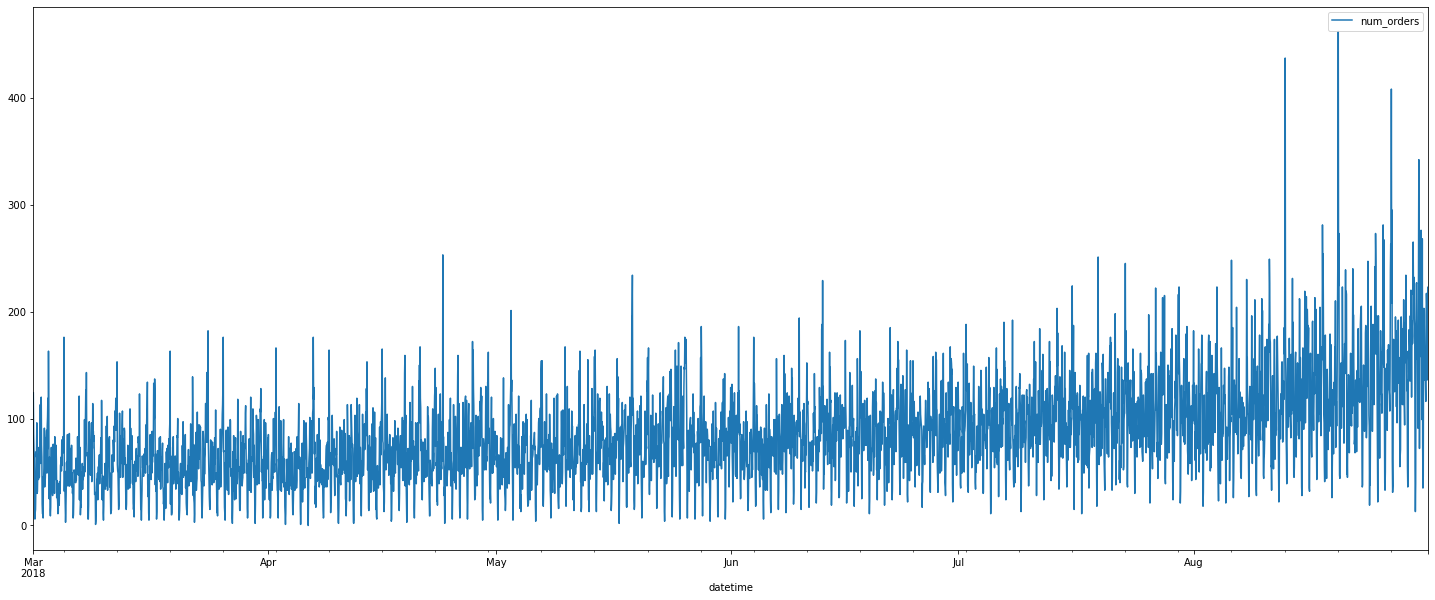

In [6]:
data.plot(figsize=(25,10))

<AxesSubplot:xlabel='datetime'>

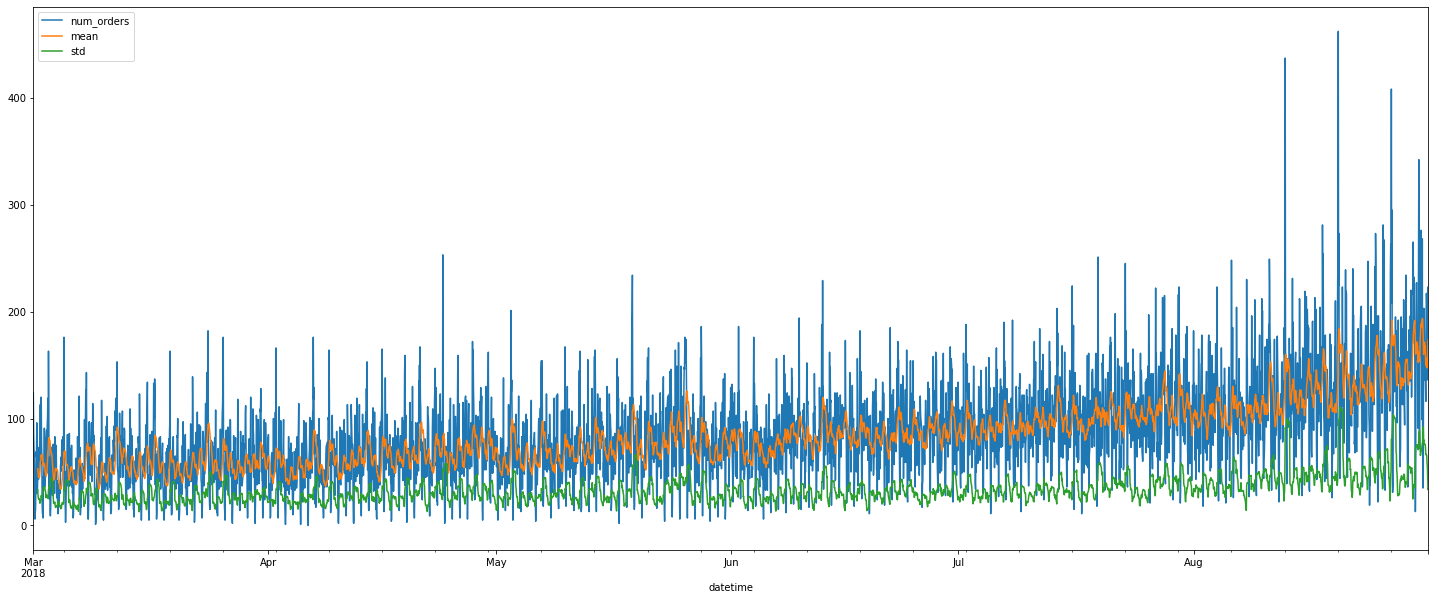

In [7]:
data_with_mean_std = data.copy()
data_with_mean_std['mean'] = data['num_orders'].rolling(15).mean()
data_with_mean_std['std'] = data['num_orders'].rolling(15).std()
data_with_mean_std.plot(figsize=(25,10))

На графике мы видим нестационарный временной ряд, нестационарный он потому, что его среднее и стандартное отклонение меняются.

Посмотрим на графики тренда и сезонности.

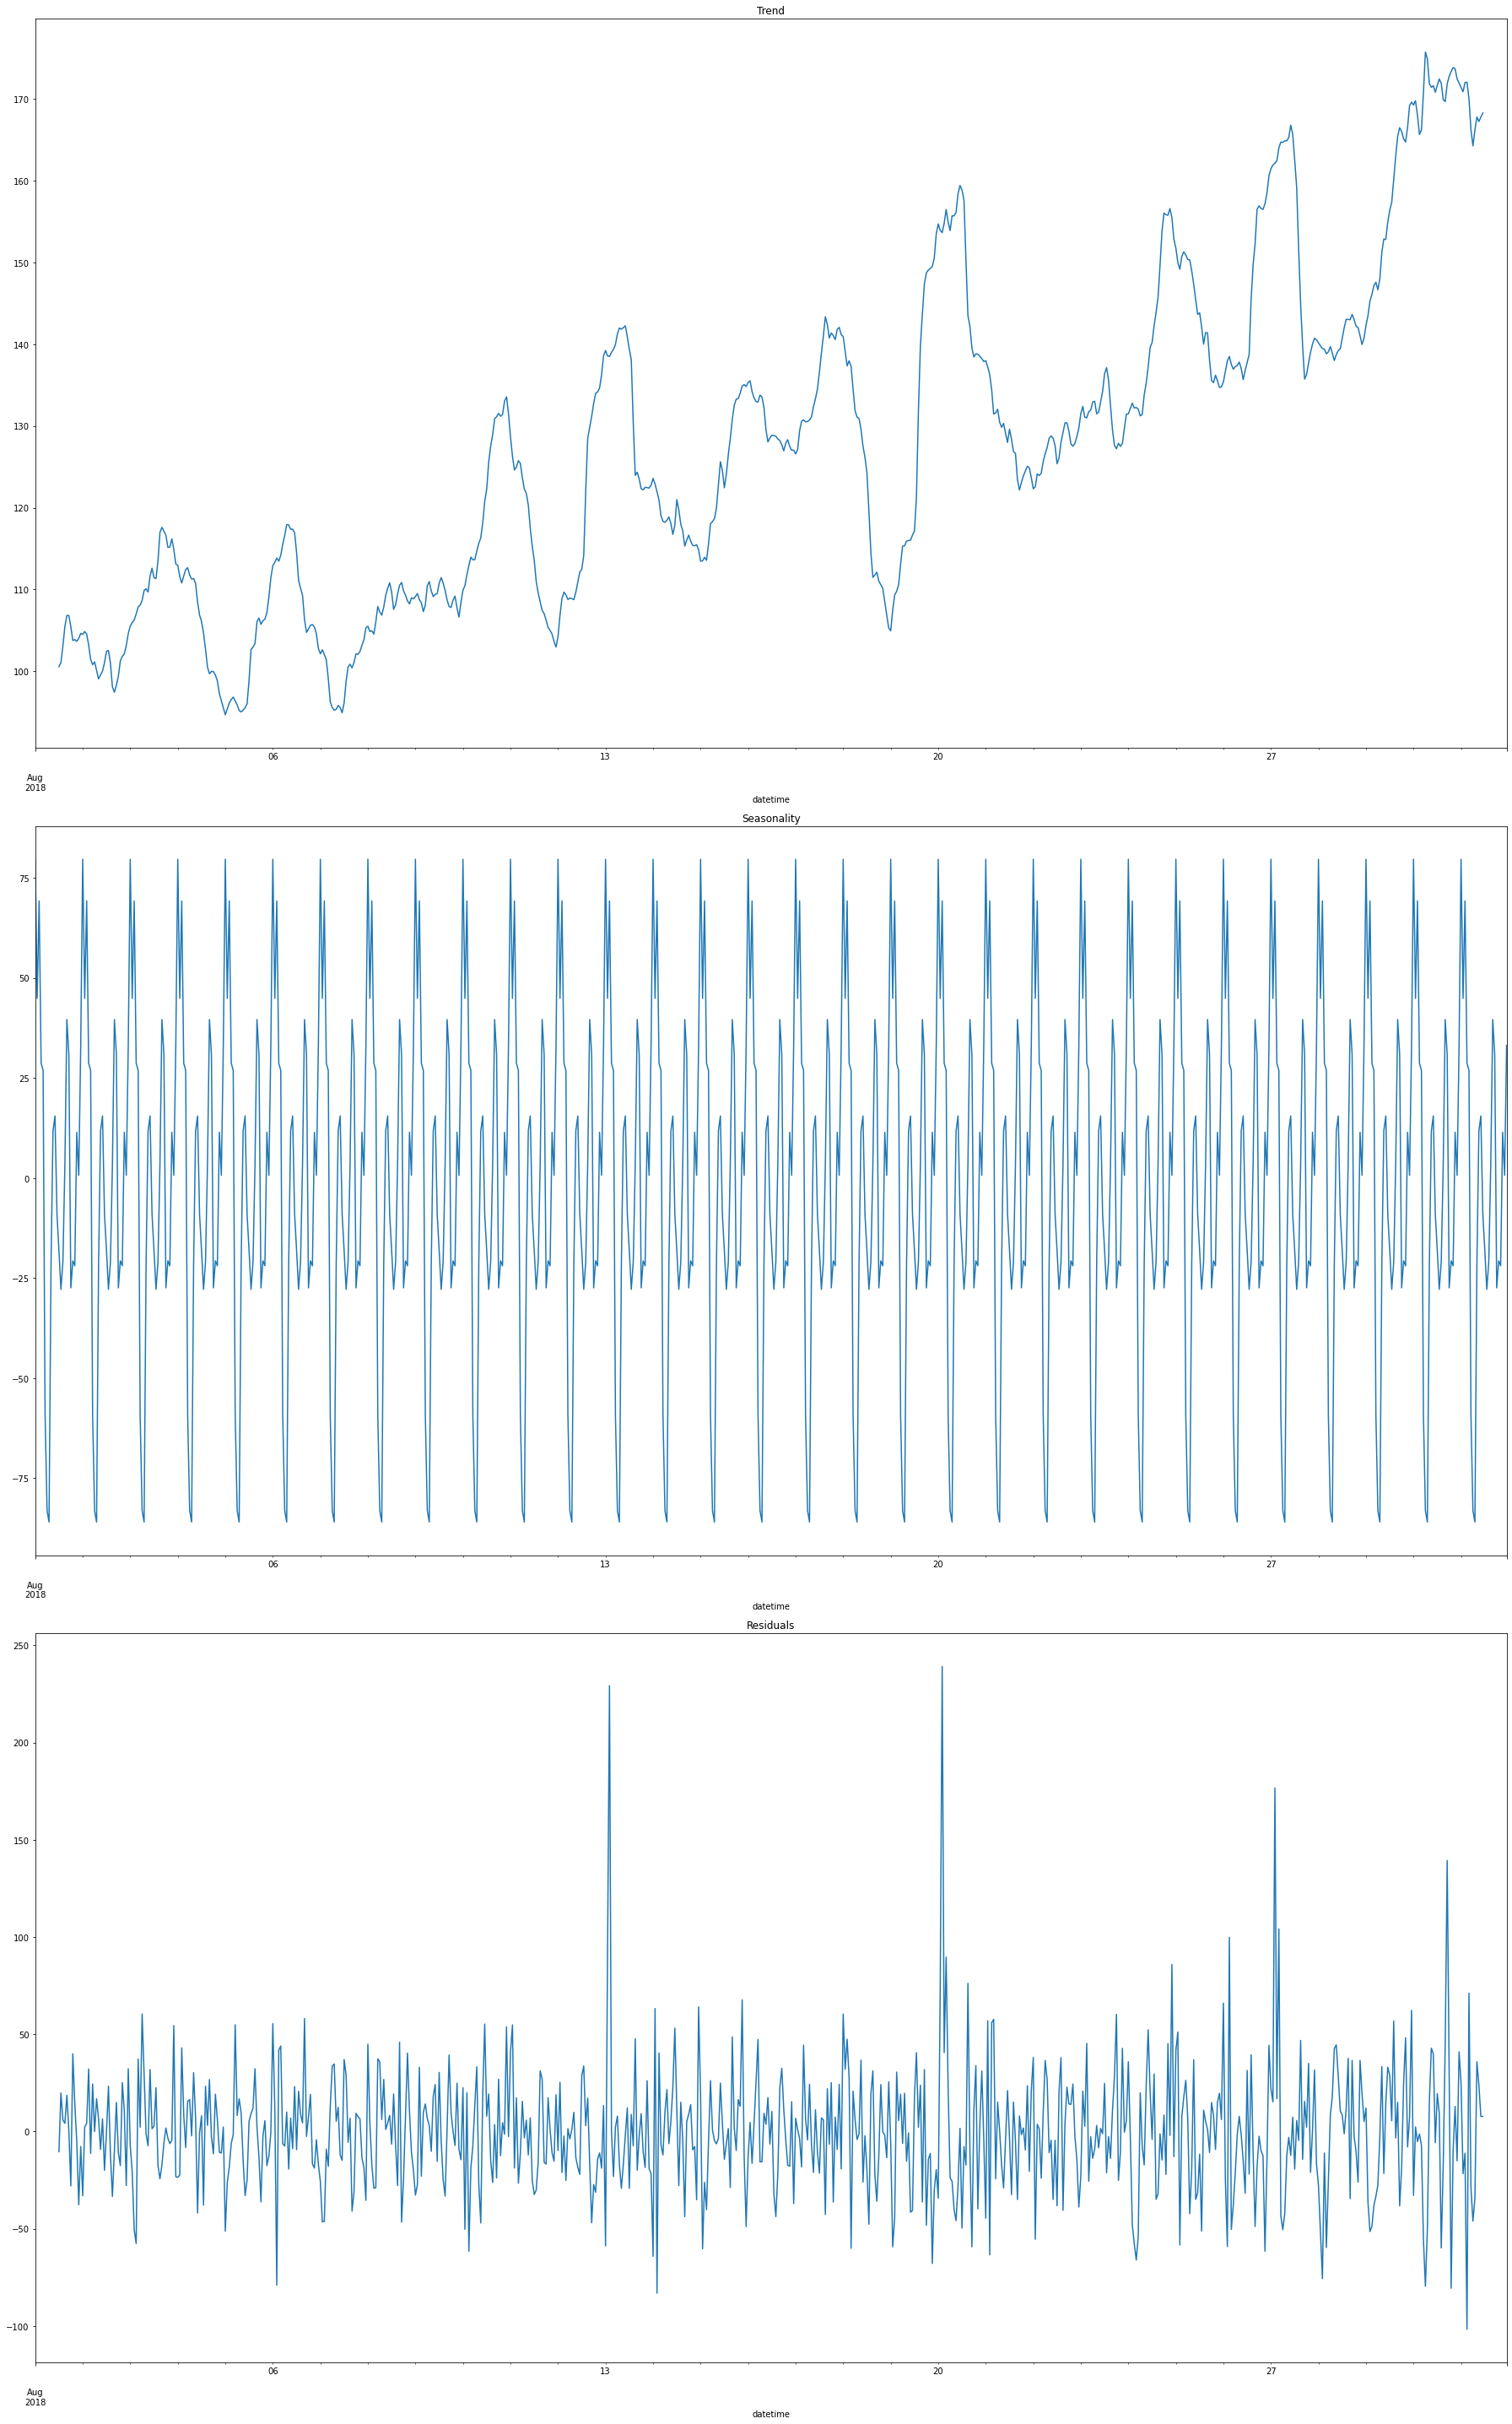

In [8]:
decomposed = seasonal_decompose(data['2018-08':'2018-09'])

plt.figure(figsize=(25,40))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В тренде мы видим положительный рост количества заказов, и наблюдаем цикличные сезонные коллебания, по сути наша сезон это один день.

## Обучение моделей

Добавим к нашему датасету признаков:
- календарные признаки - год, месяц, день, час
- отстающие значения
- скользящее среднее

Календарные мы вставим сразу, а для отстающих значений и скользящего среднего мы напишем функцию, которая будет принимать окно, для скользящего среднего и количество шагов для отстающих значений. 

Также напишем функцию для разделения данных на тренировачную и тестовую выборки и функцию похожую на GridSearchCV, для перебора lag и rolling mean.

In [9]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [10]:
def make_lags_and_rolling_mean(data, max_lag, rolling_mean_size):
    d = data.copy();
    for lag in range(1, max_lag + 1):
        d['lag_{}'.format(lag)] = d['num_orders'].shift(lag)

    d['rolling_mean'] = d['num_orders'].shift().rolling(rolling_mean_size).mean()
    return d

In [11]:
def custom_train_test_split(data, test_size):
    train, test = train_test_split(data, shuffle=False, test_size=test_size)
    train = train.dropna()

    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']

    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']
    
    return X_train, X_test, y_train, y_test

In [12]:
def lag_and_rolling_mean_search(data, model, param_grid, lags, rolling_mean_sizes):
    best_lag = 0
    best_rolling_mean_size = 0
    rmse = 0
    best_grid_params = ''
    X_train_best = []
    X_test_best = []
    y_train_best = []
    y_test_best = []
    
    for lag in lags:
        for  rolling_mean_size in  rolling_mean_sizes:
            d = make_lags_and_rolling_mean(data, lag, rolling_mean_size)
            X_train, X_test, y_train, y_test = custom_train_test_split(d, .1)
            
            my_cv = TimeSeriesSplit(n_splits=5)
            grid = GridSearchCV(estimator=model, param_grid = param_grid, cv = my_cv, n_jobs=-2, scoring='neg_mean_squared_error')            
            
            grid.fit(X_train, y_train)
                 
            grid_rmse = (grid.best_score_ * -1) ** .5
            if rmse == 0 or grid_rmse < rmse:
                rmse = grid_rmse
                best_lag = lag
                best_rolling_mean_size = rolling_mean_size
                best_grid_params = grid.best_estimator_.get_params()
                
                X_train_best = X_train
                X_test_best = X_test
                y_train_best = y_train
                y_test_best = y_test
    
    print('Best params')
    print('Hyperparams:')
    print(best_grid_params)
    print()
    print('Best lag count: {}'.format(best_lag))
    print('Best rolling mean size: {}'.format(best_rolling_mean_size))
    print('Best RMSE: {}'.format(rmse))
    
    return grid, X_train_best, X_test_best, y_train_best, y_test_best

Обучим модели линейной регрессии и CatboostRegressor.

In [13]:
linear_parameters = {'normalize': [True, False], 'fit_intercept': [True, False]}

linear_model = LinearRegression()

linear_grid, X_train, X_test, y_train, y_test = lag_and_rolling_mean_search(data, linear_model, linear_parameters, range(12,20,2), range(5,20,2))

Best params
Hyperparams:
{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'normalize': True}

Best lag count: 18
Best rolling mean size: 19
Best RMSE: 31.101819033154374


Посмотрим RMSE на тестовой выборке.

In [14]:
linear_predictions = linear_grid.predict(X_test)

In [15]:
print('LinearRegression RMSE: {}'.format(mean_squared_error(y_test, linear_predictions) ** .5))

LinearRegression RMSE: 53.83782170546206


In [16]:
catboost_parameters = {
    'depth': [6,8,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}
catboost_model = CatBoostRegressor(logging_level='Silent')

catboost_grid, X_train, X_test, y_train, y_test = lag_and_rolling_mean_search(data, catboost_model, catboost_parameters, range(8,14,2), range(8,14,2))

/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs 

Best params
Hyperparams:
{'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'RMSE', 'logging_level': 'Silent'}

Best lag count: 12
Best rolling mean size: 12
Best RMSE: 25.25349345685758


In [17]:
catboost_predictions = catboost_grid.predict(X_test)

In [18]:
print('CatBoostRegressor RMSE: {}'.format(mean_squared_error(y_test, catboost_predictions) ** .5))

CatBoostRegressor RMSE: 44.66318811766281


Нужного нам RMSE удалось достичь только с помощью CatBoostRegressor.

Проверим наши модели на адекватность.

In [19]:
d = make_lags_and_rolling_mean(data, 8, 12)

X_train, X_test, y_train, y_test = custom_train_test_split(d, .1)

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

dummy_rmse = mean_squared_error(y_test, dummy_regr.predict(X_test)) ** .5
print('Dummy RMSE: {}'.format(dummy_rmse))

Dummy RMSE: 84.69771892472764


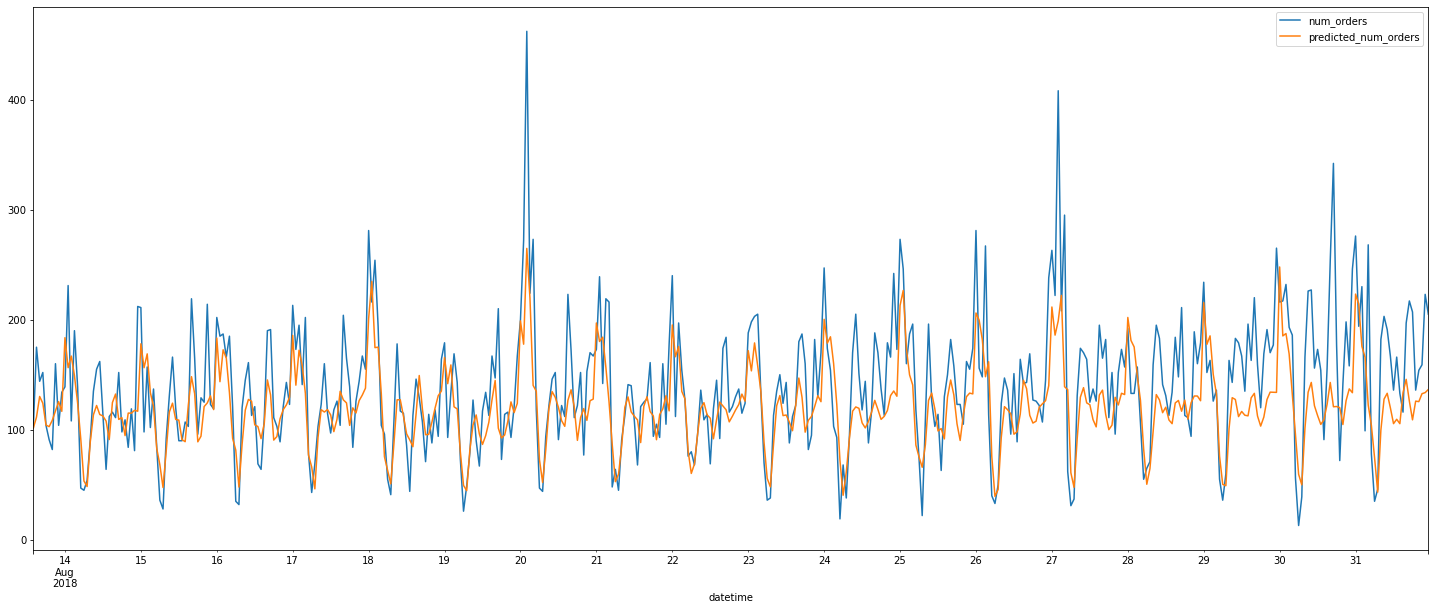

In [20]:
df_test = y_test.to_frame()
df_test['predicted_num_orders'] = catboost_predictions

df_test.plot(figsize=(25,10));

На графике мы видим как наша модель старается предсказать правильное значение, но если со средними значениями она справляеься на ура, то в пиковых мы видим явный провал.

**Вывод:** Наши модели получились адекватными и для этой задачи модель CatboostRegressor подошла больше, обучив её мы получили MAE со значением 35, против 39 у линейной регрессии. Так же можно заметить, что чем количество шагов отстающих значений больше - тем модель точнее, так же получилось, что чем меньше окно для расчета плавающего среднего, тем MAE ниже.